In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

In [2]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                   interval=50)
    anim.save('movie_cartpolr_DQN.mp4')
    display(display_animation(anim, default_mode='loop'))


In [5]:
from collections import namedtuple

Tr = namedtuple('tr', ('name_a', 'value_b'))
Tr_object = Tr('名前Aです', 100)

print(Tr_object)
print(Tr_object.value_b)
print(Tr_object.name_a)


tr(name_a='名前Aです', value_b=100)
100
名前Aです


In [6]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


In [7]:
ENV = 'CartPole-v0'
GAMMA = 0.99
MAX_STEPS = 200
NUM_EPISODES = 500

In [9]:
class ReplayMemory:
    def __init__(self, CAPACITY):
        self.capacity = CAPACITY
        self.memory = []
        self.index = 0

    def push(self, state, action, state_next, reward):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.index] = Transition(state, action, state_next, reward)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)


In [25]:
# エージェントが持つ脳となるクラスです、DQNを実行します
# Q関数をディープラーニングのネットワークをクラスとして定義

import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000


class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # CartPoleの行動（右に左に押す）の2を取得

        # 経験を記憶するメモリオブジェクトを生成
        self.memory = ReplayMemory(CAPACITY)

        # ニューラルネットワークを構築
        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(num_states, 32))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc2', nn.Linear(32, 32))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(32, num_actions))

        print(self.model)  # ネットワークの形を出力

        # 最適化手法の設定
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

    def replay(self):
        '''Experience Replayでネットワークの結合パラメータを学習'''

        # -----------------------------------------
        # 1. メモリサイズの確認
        # -----------------------------------------
        # 1.1 メモリサイズがミニバッチより小さい間は何もしない
        if len(self.memory) < BATCH_SIZE:
            return

        # -----------------------------------------
        # 2. ミニバッチの作成
        # -----------------------------------------
        # 2.1 メモリからミニバッチ分のデータを取り出す
        transitions = self.memory.sample(BATCH_SIZE)

        # 2.2 各変数をミニバッチに対応する形に変形
        # transitionsは1stepごとの(state, action, state_next, reward)が、BATCH_SIZE分格納されている
        # つまり、(state, action, state_next, reward)×BATCH_SIZE
        # これをミニバッチにしたい。つまり
        # (state×BATCH_SIZE, action×BATCH_SIZE, state_next×BATCH_SIZE, reward×BATCH_SIZE)にする
        batch = Transition(*zip(*transitions))

        # 2.3 各変数の要素をミニバッチに対応する形に変形し、ネットワークで扱えるようVariableにする
        # 例えばstateの場合、[torch.FloatTensor of size 1x4]がBATCH_SIZE分並んでいるのですが、
        # それを torch.FloatTensor of size BATCH_SIZEx4 に変換します
        # 状態、行動、報酬、non_finalの状態のミニバッチのVariableを作成
        # catはConcatenates（結合）のことです。
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])

        # -----------------------------------------
        # 3. 教師信号となるQ(s_t, a_t)値を求める
        # -----------------------------------------
        # 3.1 ネットワークを推論モードに切り替える
        self.model.eval()

        # 3.2 ネットワークが出力したQ(s_t, a_t)を求める
        # self.model(state_batch)は、右左の両方のQ値を出力しており
        # [torch.FloatTensor of size BATCH_SIZEx2]になっている。
        # ここから実行したアクションa_tに対応するQ値を求めるため、action_batchで行った行動a_tが右か左かのindexを求め
        # それに対応するQ値をgatherでひっぱり出す。
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # 3.3 max{Q(s_t+1, a)}値を求める。ただし次の状態があるかに注意。

        # cartpoleがdoneになっておらず、next_stateがあるかをチェックするインデックスマスクを作成
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None,
                                                    batch.next_state)))
        # まずは全部0にしておく
        next_state_values = torch.zeros(BATCH_SIZE)

        # 次の状態があるindexの最大Q値を求める
        # 出力にアクセスし、max(1)で列方向の最大値の[値、index]を求めます
        # そしてそのQ値（index=0）を出力します
        # detachでその値を取り出します
        next_state_values[non_final_mask] = self.model(
            non_final_next_states).max(1)[0].detach()

        # 3.4 教師となるQ(s_t, a_t)値を、Q学習の式から求める
        expected_state_action_values = reward_batch + GAMMA * next_state_values

        # -----------------------------------------
        # 4. 結合パラメータの更新
        # -----------------------------------------
        # 4.1 ネットワークを訓練モードに切り替える
        self.model.train()

        # 4.2 損失関数を計算する（smooth_l1_lossはHuberloss）
        # expected_state_action_valuesは
        # sizeが[minbatch]になっているので、unsqueezeで[minibatch x 1]へ
        loss = F.smooth_l1_loss(state_action_values,
                                expected_state_action_values.unsqueeze(1))

        # 4.3 結合パラメータを更新する
        self.optimizer.zero_grad()  # 勾配をリセット
        loss.backward()  # バックプロパゲーションを計算
        self.optimizer.step()  # 結合パラメータを更新

    def decide_action(self, state, episode):
        '''現在の状態に応じて、行動を決定する'''
        # ε-greedy法で徐々に最適行動のみを採用する
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            self.model.eval()  # ネットワークを推論モードに切り替える
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)
            # ネットワークの出力の最大値のindexを取り出します = max(1)[1]
            # .view(1,1)は[torch.LongTensor of size 1]　を size 1x1 に変換します

        else:
            # 0,1の行動をランダムに返す
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])  # 0,1の行動をランダムに返す
            # actionは[torch.LongTensor of size 1x1]の形になります

        return action


In [13]:
class Agent:
    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)

    def update_q_function(self):
        self.brain.replay()

    def get_action(self, state, episode):
        action = self.brain.decide_action(state, episode)
        return action

    def memorize(self, state, action, state_next, reward):
        self.brain.memory.push(state, action, state_next, reward)


In [27]:
# CartPoleを実行する環境のクラスです


class Environment:

    def __init__(self):
        self.env = gym.make(ENV)  # 実行する課題を設定
        num_states = self.env.observation_space.shape[0]  # 課題の状態数4を取得
        num_actions = self.env.action_space.n  # CartPoleの行動（右に左に押す）の2を取得
        self.agent = Agent(num_states, num_actions)  # 環境内で行動するAgentを生成


    def run(self):
        '''実行'''
        episode_10_list = np.zeros(10)  # 10試行分の立ち続けたstep数を格納し、平均ステップ数を出力に利用
        complete_episodes = 0  # 195step以上連続で立ち続けた試行数
        episode_final = False  # 最後の試行フラグ
        frames = []  # 最後の試行を動画にするために画像を格納する変数

        for episode in range(NUM_EPISODES):  # 最大試行数分繰り返す
            observation = self.env.reset()  # 環境の初期化

            state = observation  # 観測をそのまま状態sとして使用
            state = torch.from_numpy(state).type(
                torch.FloatTensor)  # NumPy変数をPyTorchのテンソルに変換
            state = torch.unsqueeze(state, 0)  # size 4をsize 1x4に変換

            for step in range(MAX_STEPS):  # 1エピソードのループ

                if episode_final is True:  # 最終試行ではframesに各時刻の画像を追加していく
                    frames.append(self.env.render(mode='rgb_array'))

                action = self.agent.get_action(state, episode)  # 行動を求める

                # 行動a_tの実行により、s_{t+1}とdoneフラグを求める
                # actionから.item()を指定して、中身を取り出す
                observation_next, _, done, _ = self.env.step(
                    action.item())  # rewardとinfoは使わないので_にする

                # 報酬を与える。さらにepisodeの終了評価と、state_nextを設定する
                if done:  # ステップ数が200経過するか、一定角度以上傾くとdoneはtrueになる
                    state_next = None  # 次の状態はないので、Noneを格納

                    # 直近10episodeの立てたstep数リストに追加
                    episode_10_list = np.hstack(
                        (episode_10_list[1:], step + 1))

                    if step < 195:
                        reward = torch.FloatTensor(
                            [-1.0])  # 途中でこけたら罰則として報酬-1を与える
                        complete_episodes = 0  # 連続成功記録をリセット
                    else:
                        reward = torch.FloatTensor([1.0])  # 立ったまま終了時は報酬1を与える
                        complete_episodes = complete_episodes + 1  # 連続記録を更新
                else:
                    reward = torch.FloatTensor([0.0])  # 普段は報酬0
                    state_next = observation_next  # 観測をそのまま状態とする
                    state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)  # numpy変数をPyTorchのテンソルに変換
                    state_next = torch.unsqueeze(state_next, 0)  # size 4をsize 1x4に変換

                # メモリに経験を追加
                self.agent.memorize(state, action, state_next, reward)

                # Experience ReplayでQ関数を更新する
                self.agent.update_q_function()

                # 観測の更新
                state = state_next

                # 終了時の処理
                if done:
                    print('%d Episode: Finished after %d steps：10試行の平均step数 = %.1lf' % (
                        episode, step + 1, episode_10_list.mean()))
                    break

            if episode_final is True:
                # 動画を保存と描画
                display_frames_as_gif(frames)
                break

            # 10連続で200step経ち続けたら成功
            if complete_episodes >= 10:
                print('10回連続成功')
                episode_final = True  # 次の試行を描画を行う最終試行とする


Sequential(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 13 steps：10試行の平均step数 = 1.3
1 Episode: Finished after 9 steps：10試行の平均step数 = 2.2
2 Episode: Finished after 11 steps：10試行の平均step数 = 3.3
3 Episode: Finished after 10 steps：10試行の平均step数 = 4.3
4 Episode: Finished after 9 steps：10試行の平均step数 = 5.2
5 Episode: Finished after 10 steps：10試行の平均step数 = 6.2
6 Episode: Finished after 10 steps：10試行の平均step数 = 7.2
7 Episode: Finished after 10 steps：10試行の平均step数 = 8.2
8 Episode: Finished after 11 steps：10試行の平均step数 = 9.3
9 Episode: Finished after 10 steps：10試行の平均step数 = 10.3
10 Episode: Finished after 8 steps：10試行の平均step数 = 9.8
11 Episode: Finished after 10 steps：10試行の平均step数 = 9.9
12 Episode: Finished after 10 steps：10試行の平均step数 = 9.8
13 Episode: Finished after 9 steps：10試行の平均step数 = 9.7
14 Episode: Fin

19 Episode: Finished after 8 steps：10試行の平均step数 = 9.5
20 Episode: Finished after 11 steps：10試行の平均step数 = 9.8
21 Episode: Finished after 9 steps：10試行の平均step数 = 9.7
22 Episode: Finished after 9 steps：10試行の平均step数 = 9.6
23 Episode: Finished after 9 steps：10試行の平均step数 = 9.6
24 Episode: Finished after 10 steps：10試行の平均step数 = 9.7
25 Episode: Finished after 9 steps：10試行の平均step数 = 9.5
26 Episode: Finished after 9 steps：10試行の平均step数 = 9.5
27 Episode: Finished after 9 steps：10試行の平均step数 = 9.4
28 Episode: Finished after 10 steps：10試行の平均step数 = 9.3
29 Episode: Finished after 10 steps：10試行の平均step数 = 9.5
30 Episode: Finished after 10 steps：10試行の平均step数 = 9.4
31 Episode: Finished after 14 steps：10試行の平均step数 = 9.9


32 Episode: Finished after 26 steps：10試行の平均step数 = 11.6
33 Episode: Finished after 14 steps：10試行の平均step数 = 12.1
34 Episode: Finished after 23 steps：10試行の平均step数 = 13.4
35 Episode: Finished after 42 steps：10試行の平均step数 = 16.7


36 Episode: Finished after 56 steps：10試行の平均step数 = 21.4
37 Episode: Finished after 47 steps：10試行の平均step数 = 25.2


38 Episode: Finished after 39 steps：10試行の平均step数 = 28.1
39 Episode: Finished after 26 steps：10試行の平均step数 = 29.7


40 Episode: Finished after 62 steps：10試行の平均step数 = 34.9
41 Episode: Finished after 63 steps：10試行の平均step数 = 39.8
42 Episode: Finished after 39 steps：10試行の平均step数 = 41.1


43 Episode: Finished after 58 steps：10試行の平均step数 = 45.5
44 Episode: Finished after 42 steps：10試行の平均step数 = 47.4
45 Episode: Finished after 37 steps：10試行の平均step数 = 46.9
46 Episode: Finished after 37 steps：10試行の平均step数 = 45.0


47 Episode: Finished after 43 steps：10試行の平均step数 = 44.6
48 Episode: Finished after 46 steps：10試行の平均step数 = 45.3


49 Episode: Finished after 117 steps：10試行の平均step数 = 54.4
50 Episode: Finished after 36 steps：10試行の平均step数 = 51.8
51 Episode: Finished after 66 steps：10試行の平均step数 = 52.1
52 Episode: Finished after 40 steps：10試行の平均step数 = 52.2


53 Episode: Finished after 30 steps：10試行の平均step数 = 49.4
54 Episode: Finished after 33 steps：10試行の平均step数 = 48.5
55 Episode: Finished after 32 steps：10試行の平均step数 = 48.0
56 Episode: Finished after 31 steps：10試行の平均step数 = 47.4
57 Episode: Finished after 37 steps：10試行の平均step数 = 46.8


58 Episode: Finished after 91 steps：10試行の平均step数 = 51.3
59 Episode: Finished after 38 steps：10試行の平均step数 = 43.4
60 Episode: Finished after 29 steps：10試行の平均step数 = 42.7
61 Episode: Finished after 58 steps：10試行の平均step数 = 41.9
62 Episode: Finished after 37 steps：10試行の平均step数 = 41.6


63 Episode: Finished after 46 steps：10試行の平均step数 = 43.2
64 Episode: Finished after 55 steps：10試行の平均step数 = 45.4
65 Episode: Finished after 96 steps：10試行の平均step数 = 51.8


66 Episode: Finished after 40 steps：10試行の平均step数 = 52.7
67 Episode: Finished after 35 steps：10試行の平均step数 = 52.5
68 Episode: Finished after 44 steps：10試行の平均step数 = 47.8
69 Episode: Finished after 34 steps：10試行の平均step数 = 47.4


70 Episode: Finished after 45 steps：10試行の平均step数 = 49.0
71 Episode: Finished after 75 steps：10試行の平均step数 = 50.7
72 Episode: Finished after 55 steps：10試行の平均step数 = 52.5


73 Episode: Finished after 47 steps：10試行の平均step数 = 52.6


74 Episode: Finished after 141 steps：10試行の平均step数 = 61.2
75 Episode: Finished after 68 steps：10試行の平均step数 = 58.4


76 Episode: Finished after 79 steps：10試行の平均step数 = 62.3
77 Episode: Finished after 45 steps：10試行の平均step数 = 63.3


78 Episode: Finished after 71 steps：10試行の平均step数 = 66.0
79 Episode: Finished after 61 steps：10試行の平均step数 = 68.7


80 Episode: Finished after 122 steps：10試行の平均step数 = 76.4
81 Episode: Finished after 85 steps：10試行の平均step数 = 77.4


82 Episode: Finished after 100 steps：10試行の平均step数 = 81.9
83 Episode: Finished after 166 steps：10試行の平均step数 = 93.8


84 Episode: Finished after 111 steps：10試行の平均step数 = 90.8
85 Episode: Finished after 111 steps：10試行の平均step数 = 95.1


86 Episode: Finished after 130 steps：10試行の平均step数 = 100.2
87 Episode: Finished after 108 steps：10試行の平均step数 = 106.5


88 Episode: Finished after 123 steps：10試行の平均step数 = 111.7


89 Episode: Finished after 200 steps：10試行の平均step数 = 125.6
90 Episode: Finished after 161 steps：10試行の平均step数 = 129.5


91 Episode: Finished after 162 steps：10試行の平均step数 = 137.2
92 Episode: Finished after 156 steps：10試行の平均step数 = 142.8


93 Episode: Finished after 138 steps：10試行の平均step数 = 140.0
94 Episode: Finished after 112 steps：10試行の平均step数 = 140.1


95 Episode: Finished after 117 steps：10試行の平均step数 = 140.7
96 Episode: Finished after 131 steps：10試行の平均step数 = 140.8


97 Episode: Finished after 120 steps：10試行の平均step数 = 142.0


98 Episode: Finished after 107 steps：10試行の平均step数 = 140.4
99 Episode: Finished after 125 steps：10試行の平均step数 = 132.9


100 Episode: Finished after 200 steps：10試行の平均step数 = 136.8
101 Episode: Finished after 171 steps：10試行の平均step数 = 137.7


102 Episode: Finished after 147 steps：10試行の平均step数 = 136.8
103 Episode: Finished after 200 steps：10試行の平均step数 = 143.0


104 Episode: Finished after 200 steps：10試行の平均step数 = 151.8
105 Episode: Finished after 200 steps：10試行の平均step数 = 160.1


106 Episode: Finished after 200 steps：10試行の平均step数 = 167.0
107 Episode: Finished after 200 steps：10試行の平均step数 = 175.0


108 Episode: Finished after 200 steps：10試行の平均step数 = 184.3
109 Episode: Finished after 200 steps：10試行の平均step数 = 191.8


110 Episode: Finished after 200 steps：10試行の平均step数 = 191.8
111 Episode: Finished after 200 steps：10試行の平均step数 = 194.7


112 Episode: Finished after 200 steps：10試行の平均step数 = 200.0
10回連続成功


113 Episode: Finished after 200 steps：10試行の平均step数 = 200.0


/Users/maeda/miniconda3/lib/python3.6/site-packages/matplotlib/animation.py:1218: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


ValueError: outfile must be *.htm or *.html

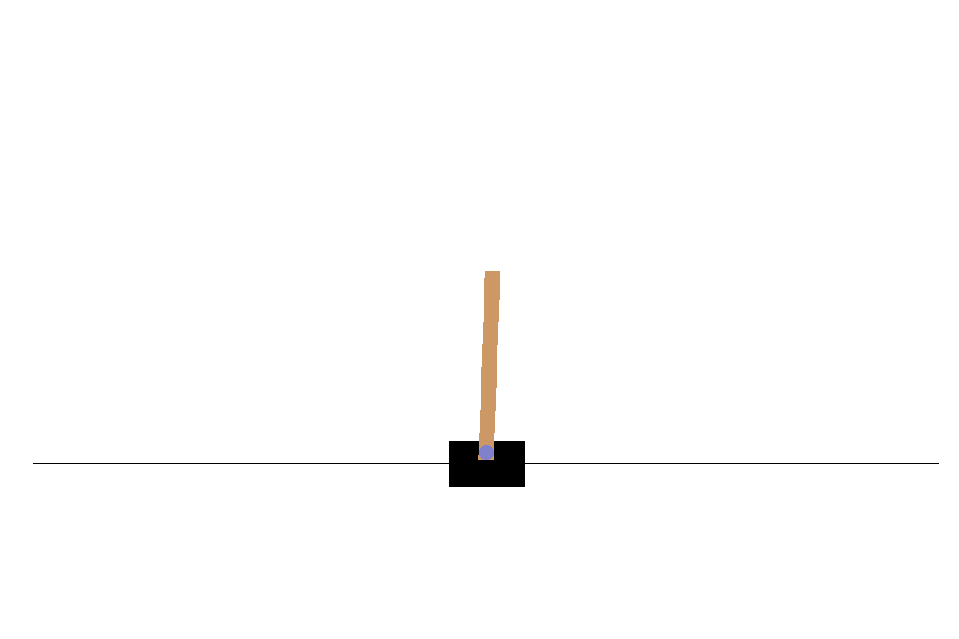

In [28]:
cartpole_env = Environment()
cartpole_env.run()